<h1 style="text-align: center;">DNA sequencing</h1>

<h4 style="text-align: center;">

Roi Jared Flores Garza Stone

Esteban Gomez Valerio

Rafael Takata Garcia

Machine Learning - O2025_MAF3654H

Ing. Juan Antonio Vega Fernández, M. Sc., M. T. Ed

ITESO
</h4>

### Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO
from Bio import Align
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

### Datos

Traemos los datos desde la libreria de biopython

In [2]:
Entrez.email = "rafael.takata@iteso.mx"
brca1_id = "NC_000017.11"


handle = Entrez.efetch(db="nucleotide", id=brca1_id, rettype="fasta", retmode="text")
brca1_record = SeqIO.read(handle, "fasta")
handle.close()

In [3]:
#Reproducibilidad
np.random.seed(32)
start = np.random.randint(low=50000, high=100000)
original_seq = brca1_record.seq[start:start+100]
original_seq

Seq('GCCTTCCGGGTAGCTAGGATTACAGGTGGACGCTACCACGTCCGGCTAATTTTT...ATT')

### Funciones

In [4]:
#Needleman Wunsch
def needleman_wunsch(seq1, seq2, match_score=2, mismatch_score=-1, gap_penalty=-2):
    n = len(seq1)
    m = len(seq2)
    score_matrix = np.zeros((n + 1, m + 1), dtype=int)
    traceback_matrix = np.zeros((n + 1, m + 1), dtype=int)

    # Initialization
    for i in range(n + 1):
        score_matrix[i, 0] = i * gap_penalty
    for j in range(m + 1):
        score_matrix[0, j] = j * gap_penalty

    # Matrix Fill
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            match = score_matrix[i - 1, j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_score)
            delete = score_matrix[i - 1, j] + gap_penalty
            insert = score_matrix[i, j - 1] + gap_penalty
            score_matrix[i, j] = max(match, delete, insert)
            
            # Store direction for traceback: 1=diag, 2=up, 3=left
            if score_matrix[i, j] == match:
                traceback_matrix[i, j] = 1
            elif score_matrix[i, j] == delete:
                traceback_matrix[i, j] = 2
            else:
                traceback_matrix[i, j] = 3

    # Traceback to build alignment
    aligned_seq1 = []
    aligned_seq2 = []
    i, j = n, m
    while i > 0 or j > 0:
        if traceback_matrix[i, j] == 1: # Diagonal move
            aligned_seq1.append(seq1[i-1])
            aligned_seq2.append(seq2[j-1])
            i -= 1
            j -= 1
            
        elif traceback_matrix[i, j] == 2: # Up move (gap in seq2)
            aligned_seq1.append(seq1[i-1])
            aligned_seq2.append('-')
            i -= 1
            
        else: # Left move (gap in seq1)
            aligned_seq1.append('-')
            aligned_seq2.append(seq2[j-1])
            j -= 1
    
    return "".join(reversed(aligned_seq1)), "".join(reversed(aligned_seq2)), score_matrix, score_matrix[n, m]


In [5]:
#Smith Waterman
def smith_waterman(seq1, seq2, match_score=2, mismatch_score=-1, gap_penalty=-2):
    n, m = len(seq1), len(seq2)
    score_matrix = np.zeros((n+1, m+1), dtype=int)
    
    max_score = 0
    max_pos = (0,0)
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            
            match = score_matrix[i-1, j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch_score)
            delete = score_matrix[i-1, j] + gap_penalty
            insert = score_matrix[i, j-1] + gap_penalty
            
            score_matrix[i, j] = max(0, match, delete, insert)
            
            if score_matrix[i, j] > max_score:
                max_score = score_matrix[i, j]
                max_pos = (i, j)
                
    aligned_seq1, aligned_seq2 = [], []
    i, j = max_pos
    
    while score_matrix[i, j] > 0:
        current_score = score_matrix[i, j]
        diagonal_score = score_matrix[i-1, j-1]
        up_score = score_matrix[i-1, j]
        left_score = score_matrix[i, j-1]
        
        if current_score == diagonal_score + (match_score if seq1[i-1] == seq2[j-1] else mismatch_score):
            aligned_seq1.append(seq1[i-1])
            aligned_seq2.append(seq2[j-1])
            i -= 1
            j -= 1
            
        elif current_score == up_score + gap_penalty:
            aligned_seq1.append(seq1[i-1])
            aligned_seq2.append("-")
            i -= 1
            
        else: 
            aligned_seq1.append("-")
            aligned_seq2.append(seq2[j-1])
            j -= 1
            
    return "".join(reversed(aligned_seq1)), "".join(reversed(aligned_seq2)), max_score, score_matrix 


In [13]:
def output(score_nw, aligned_nw1, aligned_nw2, original_seq, variant1_seq, score_matrix_nw, title, plt_nmb):    
    
    print(f"--- {title} ---")
    print(f"Alignment Score: {score_nw}")
    print(f"Aligned Sequence 1: {aligned_nw1[:100]}...")
    print(f"Aligned Sequence 2: {aligned_nw2[:100]}...")
    print(f"...\n")

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(score_matrix_nw, annot=False, cmap='viridis', fmt='d')
    plt.title(title)
    plt.xlabel(f"Sequence 2 ({len(variant1_seq)} bp)")
    plt.ylabel(f"Sequence 1 ({len(original_seq)} bp)")
    
    plt.savefig(f"heatmaps/DNA_sequencing_{plt_nmb}.png")
    
    plt.show()

### Secuencias a probar

In [14]:
original_seq1 = """GACTTACGCGCCGTAGCACTTCTGTGATAGCTGCGAGGCGTATTGCTACTTGTACGAGATAGGGTCGACTTT
TCGGAGTCGACAGACACTACGATACT"""
variant1_seq1 = """AGTATCGTAGTGTCTGTCGACTCCGAAAAGTCGACCCTATCTCGTACAAGTAGCAATACGCCTCGCAGCTAT
CACAGAAGTGCTACGGCGCGTAAGTC"""

original_seq2 = """TTAAATTATATATATACGCGCGCGCGACACACACACACTGATCTATACGCGCGCGCGCGATAGCGATAGCGA
TCGATCGCGCTATATATATA"""
variant1_seq2 = """TATATATAGCGCGATCGATCGCTATCGCTATCGCGCGCGCGTATAGATCAGTGTGTGTGTGTCGCGCGCGCG
TATATATATAATTTAA""" 

original_seq3 = """CTACTGAGTCGTAGCTAGCGAGTCGAGTGCGTGCATGCATGCATGCATGCATGCATGCATGCATGCATGCAT
GCATGCATGCATGCATGC"""
variant1_seq3 = """GCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCACGACTCGACTCGCTAGC
TACGACTCAGTAG"""

In [15]:
print(f"Original sequence length: {len(original_seq)} bp")
print(f"Variant 1 sequence length: {len(original_seq1)} bp")
print(f"Variant 2 sequence length: {len(variant1_seq1)} bp")

Original sequence length: 100 bp
Variant 1 sequence length: 99 bp
Variant 2 sequence length: 99 bp


### Comparación - Secuencia 1

--- Needleman-Wunsch Score Matrix (Global Alignment) - seq #1 - pen:normal ---
Alignment Score: 46
Aligned Sequence 1: GCCTTCCGGGTAGCTAGGATTACAGGTGGACGCTACCACGTCCGGCTAATTTTTGTATTTTTAGTACAGACGG--GGCTTCATCATCTTGGCCAG--GCT...
Aligned Sequence 2: GACTTACGCGCCG-TAGCACTTC-TGTGATAGCTGCGA-G-GC-G-T-A--TTGCTACTTGTACGAGATAGGGTCGACTTT
TCGGAGTCGACAGACACT...
...



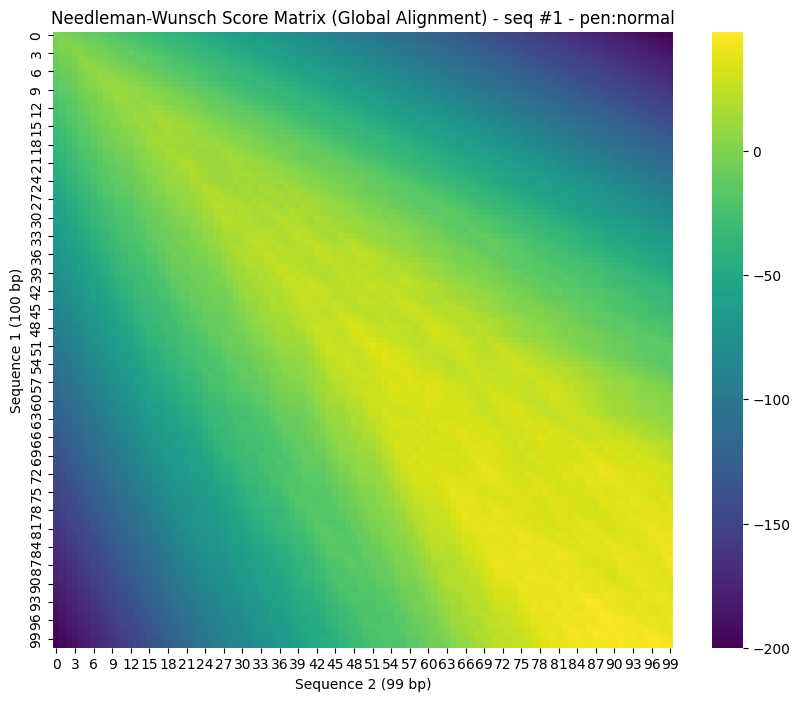

In [23]:
aligned_nw1, aligned_nw2, score_matrix_nw, score_nw = needleman_wunsch(original_seq, original_seq1)

output(score_nw=score_nw, aligned_nw1=aligned_nw1, aligned_nw2=aligned_nw2,
       original_seq=original_seq, variant1_seq=variant1_seq1, score_matrix_nw=score_matrix_nw, 
       title="Needleman-Wunsch Score Matrix (Global Alignment) - seq #1 - pen:normal", plt_nmb=1)

--- Smith-Waterman Alignment - se1 #1 - pen:normal ---
Alignment Score: 46
Aligned Sequence 1: GCCTTCCGGGTAGCTAGGATTACAGGTGGACGCTACCACGTCCGGCTAATTTTTGTATTTTTAGTACAGACGG--GGCTTCATCATCTTGGCCAG--GCT...
Aligned Sequence 2: GACTTACGCGCCG-TAGCACTTC-TGTGATAGCTGCGA-G-GC-G-T-A--TTGCTACTTGTACGAGATAGGGTCGACTTT
TCGGAGTCGACAGACACT...
...



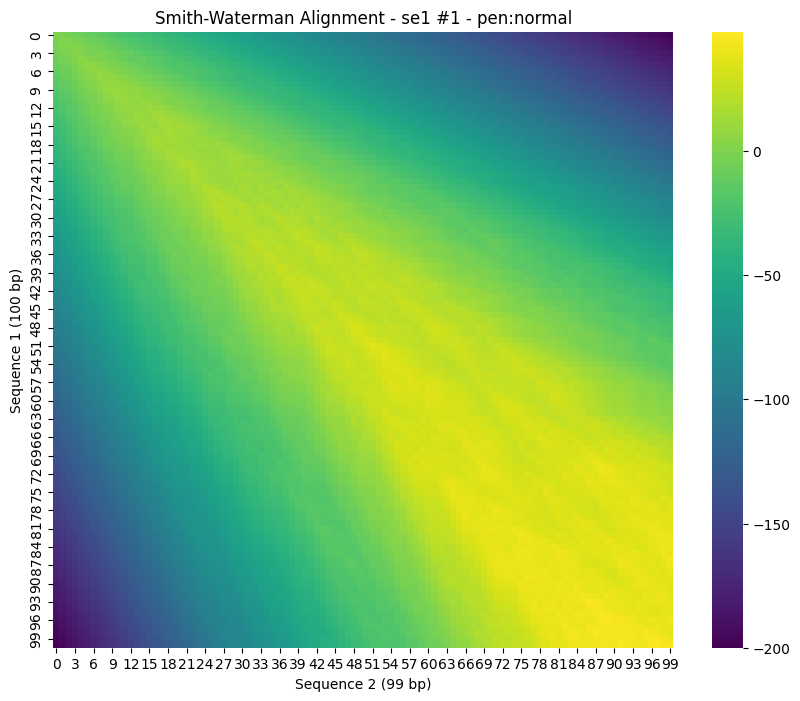

In [24]:
aligned_sw1, aligned_sw2, score_sw, score_matrix_sw = smith_waterman(original_seq, variant1_seq1)

output(score_nw=score_nw, aligned_nw1=aligned_nw1, aligned_nw2=aligned_nw2,
       original_seq=original_seq, variant1_seq=variant1_seq1, score_matrix_nw=score_matrix_nw,
       title="Smith-Waterman Alignment - se1 #1 - pen:normal", plt_nmb=2)

### Secuencia 2

--- Needleman-Wunsch Score Matrix (Global Alignment) - sec #2 - pen:normal ---
Alignment Score: 16
Aligned Sequence 1: GC-C-----------TTCCGGGTAGCTAGGATTACAGGTGGACGCTAC-CACGTCCGGCTAATTTTTGTATTTTTAGTAC-AGACGGGGCT-TC-A-TC-...
Aligned Sequence 2: CGCGCTATATATATATT-AAATTA--TA-TA-TATACGCGCGCGCGACACAC-ACACACTGA--TCTATA-CGCGCGCGCGCGATAGCGATAGCGA
TCG...
...



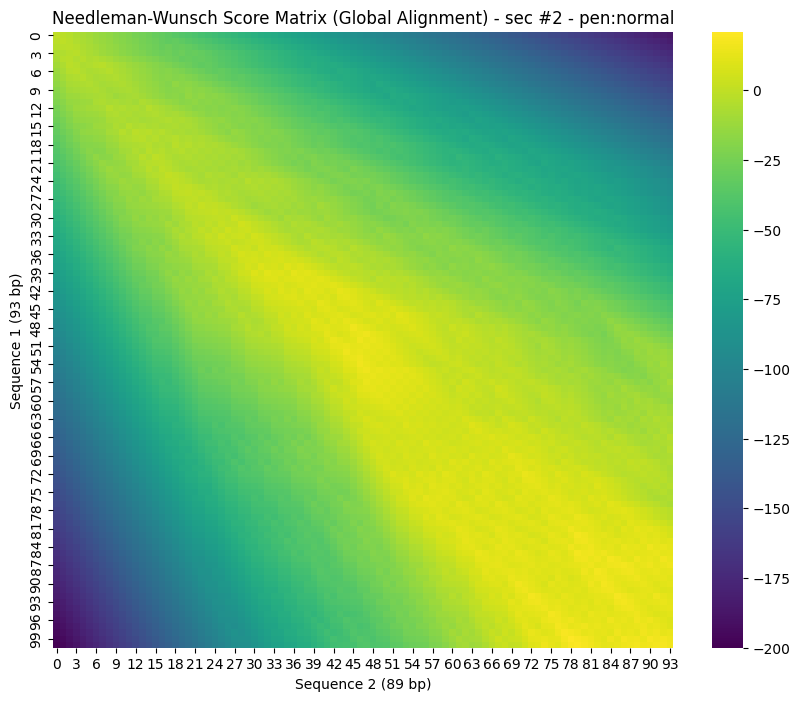

In [25]:
aligned_nw1, aligned_nw2, score_matrix_nw, score_nw = needleman_wunsch(original_seq, original_seq2)
output(score_nw=score_nw, aligned_nw1=aligned_nw1, aligned_nw2=aligned_nw2,
       original_seq=original_seq2, variant1_seq=variant1_seq2, score_matrix_nw=score_matrix_nw, 
       title="Needleman-Wunsch Score Matrix (Global Alignment) - sec #2 - pen:normal", plt_nmb=3)

--- Smith-Waterman Alignment  - sec #2 - pen:normal ---
Alignment Score: 16
Aligned Sequence 1: GC-C-----------TTCCGGGTAGCTAGGATTACAGGTGGACGCTAC-CACGTCCGGCTAATTTTTGTATTTTTAGTAC-AGACGGGGCT-TC-A-TC-...
Aligned Sequence 2: CGCGCTATATATATATT-AAATTA--TA-TA-TATACGCGCGCGCGACACAC-ACACACTGA--TCTATA-CGCGCGCGCGCGATAGCGATAGCGA
TCG...
...



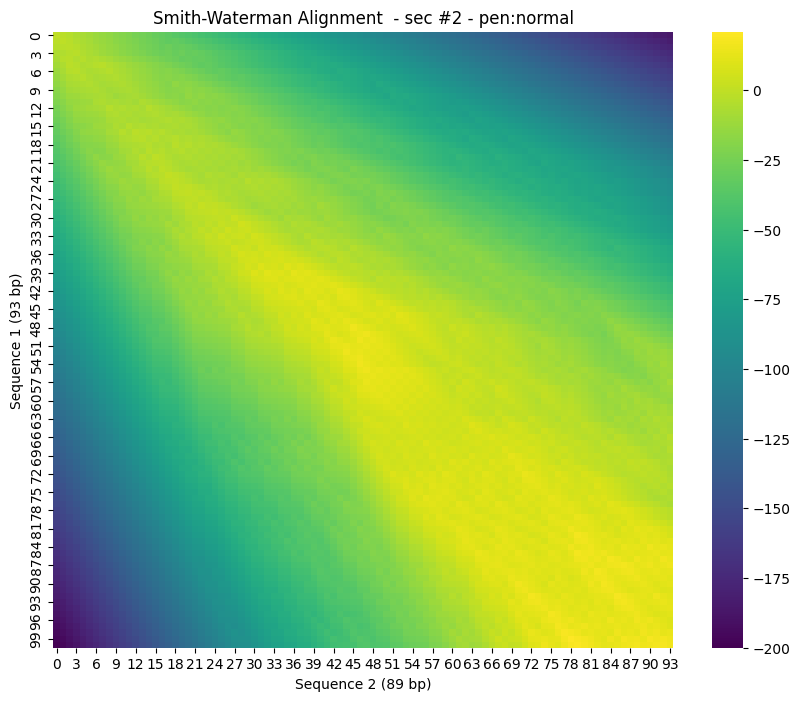

In [26]:
aligned_sw1, aligned_sw2, score_sw, score_matrix_sw = smith_waterman(original_seq, variant1_seq2)

output(score_nw=score_nw, aligned_nw1=aligned_nw1, aligned_nw2=aligned_nw2,
       original_seq=original_seq2, variant1_seq=variant1_seq2, score_matrix_nw=score_matrix_nw,
       title="Smith-Waterman Alignment  - sec #2 - pen:normal", plt_nmb=4)

### Secuencia 3

--- Needleman-Wunsch Score Matrix (Global Alignment) - sec #3 - pen:normal ---
Alignment Score: 27
Aligned Sequence 1: GCCTTCCGGGTAGCTAGGATTACAGGTGGACGCTACCACGTCCGGCTAATTTTTGTATTTTTAGTACAGACGGGGCTTCATCATCTTGGCCAGGCTGATT...
Aligned Sequence 2: G-CAT--GCAT-GC-ATGCATGCA--TGCATGCATGCATG-CATGC--ATGCATGCATGCAT-GCAC-GACTCGAC-TCGCTAGC
T-ACGACTCAGTAG...
...



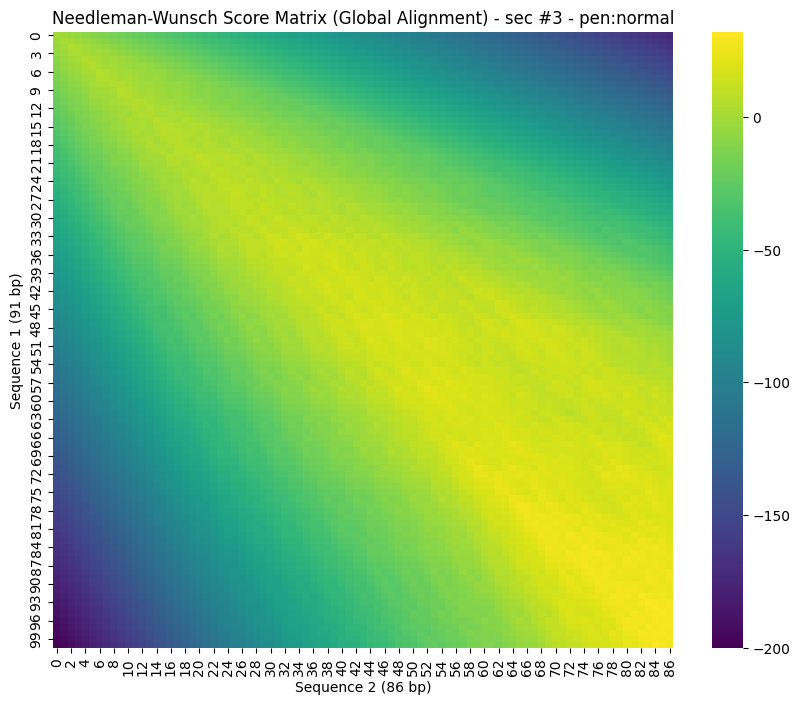

In [28]:
aligned_nw1, aligned_nw2, score_matrix_nw, score_nw = needleman_wunsch(original_seq, variant1_seq3)
output(score_nw=score_nw, aligned_nw1=aligned_nw1, aligned_nw2=aligned_nw2,
       original_seq=original_seq3, variant1_seq=variant1_seq3, score_matrix_nw=score_matrix_nw, 
       title="Needleman-Wunsch Score Matrix (Global Alignment) - sec #3 - pen:normal", plt_nmb=5)


--- Smith-Waterman Alignment - sec #3 - pen:normal ---
Alignment Score: 27
Aligned Sequence 1: GCCTTCCGGGTAGCTAGGATTACAGGTGGACGCTACCACGTCCGGCTAATTTTTGTATTTTTAGTACAGACGGGGCTTCATCATCTTGGCCAGGCTGATT...
Aligned Sequence 2: G-CAT--GCAT-GC-ATGCATGCA--TGCATGCATGCATG-CATGC--ATGCATGCATGCAT-GCAC-GACTCGAC-TCGCTAGC
T-ACGACTCAGTAG...
...



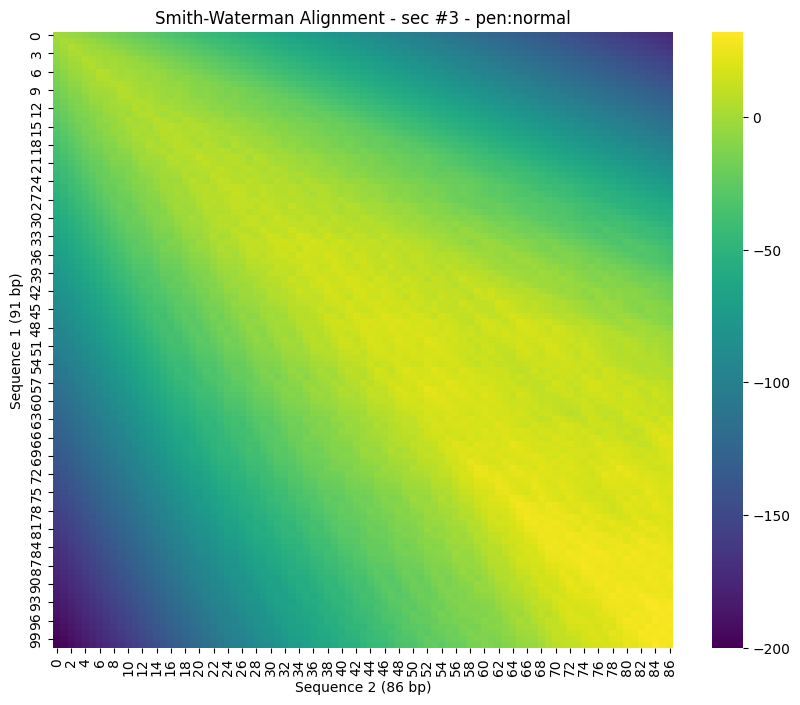

In [29]:
aligned_sw1, aligned_sw2, score_sw, score_matrix_sw = smith_waterman(original_seq3, variant1_seq3)

output(score_nw=score_nw, aligned_nw1=aligned_nw1, aligned_nw2=aligned_nw2,
       original_seq=original_seq3, variant1_seq=variant1_seq3, score_matrix_nw=score_matrix_nw,
       title="Smith-Waterman Alignment - sec #3 - pen:normal", plt_nmb=6)